In [110]:
# import required libraries
import pandas as pd
import numpy as np
import os
import json
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading
I loaded in the files for each search location, extracted the dictionaries and turned them into columns, and concatenated them all to build one dataset per search location. In the end, I have three dataframes. One for DC, one for US, and one with both. I also added a column for the search location to know which data came from where.

This code for the DC search.

In [111]:
# path to the folder containing data files
folder_path = '../Data/DC_Search/'

# create an empty list to store the dataframes
dfs = []

# loop over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a JSON file
    if filename.endswith('.json'):
        # read JSON file
        with open(os.path.join(folder_path, filename)) as f:
            data = json.load(f)

        # extract the "jobs_results" dictionary
        jobs_results = data['jobs_results']

        # convert the dictionary into a DataFrame
        df = pd.DataFrame.from_dict(jobs_results)

        # append the dataframe to the list of dataframes
        dfs.append(df)

# concatenate all the dataframes into one
final_df = pd.concat(dfs, ignore_index=True)

### extracting dictionaries from detected_extensions column
# Assuming your DataFrame is named "df"
def extract_dict_columns(d):
    """Custom function to extract dictionary keys into separate columns"""
    keys = ["schedule_type", "salary", "posted_at", "work_from_home"]
    return {
        "schedule_type": d.get("schedule_type", np.nan),
        "salary": d.get("salary", np.nan),
        "posted_at": d.get("posted_at", np.nan),
        "work_from_home": d.get("work_from_home", np.nan)
    }

# Use apply method with the custom function to extract the dictionary keys into separate columns
final_df[["schedule_type", "salary", "posted_at", "work_from_home"]] = final_df["detected_extensions"].apply(lambda x: pd.Series(extract_dict_columns(x)))

# Drop the original column containing the nested dictionaries
final_df = final_df.drop(["detected_extensions", "job_id", "related_links", "extensions"], axis=1)

# get qualifications, responsibilities, and benefits
quals = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[0])['items']
resps = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[1])['items']
bens = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[2])['items']

# add to dataframe as columns
final_df['Qualifications'] = quals
final_df['Responsibilities'] = resps
final_df['Benefits'] = bens

# drop job_highlights column
final_df = final_df.drop(['job_highlights'], axis=1)

# add a column for the search location
final_df['Search_Location'] = 'DC'

# rename it to DC_search
DC_search = final_df

Repeat the same process for the US search.

In [112]:
# path to the folder containing data files
folder_path = '../Data/USA_Search/'

# create an empty list to store the dataframes
dfs = []

# loop over all files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a JSON file
    if filename.endswith('.json'):
        # read JSON file
        with open(os.path.join(folder_path, filename)) as f:
            data = json.load(f)

        # extract the "jobs_results" dictionary
        jobs_results = data['jobs_results']

        # convert the dictionary into a DataFrame
        df = pd.DataFrame.from_dict(jobs_results)

        # append the dataframe to the list of dataframes
        dfs.append(df)

# concatenate all the dataframes into one
final_df = pd.concat(dfs, ignore_index=True)

### extracting dictionaries from detected_extensions column
# Assuming your DataFrame is named "df"
def extract_dict_columns(d):
    """Custom function to extract dictionary keys into separate columns"""
    keys = ["schedule_type", "salary", "posted_at", "work_from_home"]
    return {
        "schedule_type": d.get("schedule_type", np.nan),
        "salary": d.get("salary", np.nan),
        "posted_at": d.get("posted_at", np.nan),
        "work_from_home": d.get("work_from_home", np.nan)
    }

# Use apply method with the custom function to extract the dictionary keys into separate columns
final_df[["schedule_type", "salary", "posted_at", "work_from_home"]] = final_df["detected_extensions"].apply(lambda x: pd.Series(extract_dict_columns(x)))

# Drop the original column containing the nested dictionaries
final_df = final_df.drop(["detected_extensions", "job_id", "related_links", "extensions"], axis=1)

# get qualifications, responsibilities, and benefits
quals = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[0])['items']
resps = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[1])['items']
bens = pd.json_normalize(pd.json_normalize(final_df['job_highlights'])[2])['items']

# add to dataframe as columns
final_df['Qualifications'] = quals
final_df['Responsibilities'] = resps
final_df['Benefits'] = bens

# drop job_highlights column
final_df = final_df.drop(['job_highlights'], axis=1)

# add a column for the search location
final_df['Search_Location'] = 'USA'

# rename it to DC_search
USA_search = final_df

Concatenate the two dataframes.

In [113]:
# concatenate the two dataframes
all = pd.concat([DC_search, USA_search], ignore_index=True)

## Data Processing and Cleaning

- Removing duplicates
- Strip leading and trailing whitespace from posted_at column
- Clean posted_at column
- Cleaning via column

In [114]:
# remove duplicate rows
all = all.drop_duplicates(subset=['description'], keep='first')

# remove "ago" from posted_at column
all['posted_at'] = all['posted_at'].str.replace('ago', '')

# strip leading or trailing whitespace from posted_at column
all['posted_at'] = all['posted_at'].str.strip()

# change NaNs to not available
all['posted_at'] = all['posted_at'].fillna('Not Available')

# change anything that has hours to 1 day
all['posted_at'] = all['posted_at'].apply(lambda x: '1 day' if 'hour' in x else x)

# remove the one row that has month in posted_at column
all = all[all['posted_at'] != '1 month']

# change "not available" to NaN
all['posted_at'] = all['posted_at'].replace('Not Available', np.nan)

# remove days and day from posted_at column and keep only the number
all['posted_at'] = all['posted_at'].str.replace(' days', '')
all['posted_at'] = all['posted_at'].str.replace(' day', '')

# change posted_at column name to days_posted
all = all.rename(columns={'posted_at': 'days_posted'})

# removing "via" from via column
all['via'] = all['via'].str.replace('via ', '')

# remove trailing and leading whitespace from via column
all['via'] = all['via'].str.strip()

# remove leading and trailing whitespace from all text columns
all['title'] = all['title'].str.strip()
all['company_name'] = all['company_name'].str.strip()
all['location'] = all['location'].str.strip()
all['description'] = all['description'].str.strip()
all['schedule_type'] = all['schedule_type'].str.strip()
all['salary'] = all['salary'].str.strip()

# add salary ranges columns
# change benefit NaNs to a list with "Not Available"
all['Benefits'] = all['Benefits'].fillna('Not Available')
salaries = []

for x in all['Benefits']:
    if x == 'Not Available':
        salaries.append([np.nan])
    elif re.findall(r'\$\d+(?:,\d+)*(?:\.\d+)?', ''.join(x)):
        salaries.append(re.findall(r'\$\d+(?:,\d+)*(?:\.\d+)?', ''.join(x)))
    else:
        salary_found = False
        for y in x:
            if re.findall(r'\$\d+(?:,\d+)*(?:\.\d+)?', y) == []:
                continue
            else:
                salaries.append(re.findall(r'\$\d+(?:,\d+)*(?:\.\d+)?', y))
                salary_found = True
        if not salary_found:
            salaries.append([np.nan])

# return the first and last value of each list within salaries
min_salary = [x[0] for x in salaries]
max_salary = [x[-1] for x in salaries]

# add min and max salary columns to dataframe
all['min_salary'] = min_salary
all['max_salary'] = max_salary

Based on an average work hours per year of 2,087, I calculated the yearly salary for each job posting.

In [115]:
# remove unnecessary text from salary column
sals = all['salary'].str.split(' ', 1).str[0]

# replace NaNs with 0-0
sals = sals.fillna('0-0')

# split the salary column into min and max salary columns
myl = []
for value in sals:
    split_values = re.split("-|–", value)
    myl.append(split_values)

# split myl into two lists
min_sal = [x[0] for x in myl]
max_sal = [x[-1] for x in myl]

# add min and max salary columns to dataframe
all['min_sal'] = min_sal
all['max_sal'] = max_sal

# if min_sal or max_sal has a K, replace it with 000
all['min_sal'] = all['min_sal'].str.replace('K', '000')
all['max_sal'] = all['max_sal'].str.replace('K', '000')

# remove commas from min_sal and max_sal columns
all['min_sal'] = all['min_sal'].str.replace(',', '')
all['max_sal'] = all['max_sal'].str.replace(',', '')

# change min_sal and max_sal columns to numeric
all['min_sal'] = pd.to_numeric(all['min_sal'])
all['max_sal'] = pd.to_numeric(all['max_sal'])

# if min_sal or max_sal is less than 300, multiply by 2087
all['min_sal'] = all['min_sal'].apply(lambda x: x*2087 if x < 300 else x)
all['max_sal'] = all['max_sal'].apply(lambda x: x*2087 if x < 300 else x)

# if min_salary, max_salary are empty, fill them with min_sal, max_sal
all['min_salary'] = all['min_salary'].fillna(all['min_sal'])
all['max_salary'] = all['max_salary'].fillna(all['max_sal'])

# remove min_sal and max_sal columns
all = all.drop(['min_sal', 'max_sal'], axis=1)

# remove $ and , from min_salary and max_salary columns and turn them into floats
all['min_salary'] = all['min_salary'].apply(lambda x: str(x).replace(',', '').replace('$', '') if isinstance(x, str) else x).astype(float)
all['max_salary'] = all['max_salary'].apply(lambda x: str(x).replace(',', '').replace('$', '') if isinstance(x, str) else x).astype(float)

/var/folders/jc/37t7tc411k5_r_7l10g6cy6r0000gn/T/ipykernel_7063/3256195869.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  sals = all['salary'].str.split(' ', 1).str[0]


Find the rows with errors to manually fix them.

In [116]:
import pandas as pd

# index 15
all.loc[15, 'max_salary'] = 245700

# index 94
all.loc[94, 'max_salary'] = 100000
all.loc[94, 'min_salary'] = 80000

# index 105
all.loc[105, 'max_salary'] = 370000
all.loc[105, 'min_salary'] = 200000

# index 218
all.loc[218, 'max_salary'] = 370000
all.loc[218, 'min_salary'] = 200000

# index 224
all.loc[224, 'max_salary'] = 335000
all.loc[224, 'min_salary'] = 230000

# index 258
all.loc[258, 'max_salary'] = 100000
all.loc[258, 'min_salary'] = 80000

# index 344
all.loc[344, 'max_salary'] = 335000
all.loc[344, 'min_salary'] = 196000

# index 481
all.loc[481, 'max_salary'] = 28*2087
all.loc[481, 'min_salary'] = 20*2087

# index 582
all.loc[582, 'max_salary'] = 100000
all.loc[582, 'min_salary'] = 80000

# index 739
all.loc[739, 'max_salary'] = 250128
all.loc[739, 'min_salary'] = 168070


## Feature Engineering

In [117]:
# remove salary column
all = all.drop(['salary'], axis=1)

In [118]:
# create column for range between min and max salary
all['salary_range'] = all['max_salary'] - all['min_salary']

# create column for length of benefits
all['benefits_length'] = all['Benefits'].apply(lambda x: len(x))

# create column for length of qualifications
all['quals_length'] = all['Qualifications'].apply(lambda x: len(x))

# replace NaNs with "Not Available" in Responsibilities column
all['Responsibilities'] = all['Responsibilities'].fillna('Not Available')
# create column for length of responsibilities
all['resps_length'] = all['Responsibilities'].apply(lambda x: len(x))

Drop a couple more duplicates.

In [119]:
# drop duplicates
all = all.drop_duplicates(subset=['title', 'company_name', 'location', 'quals_length'], keep='first')

Fix work_from_home column.

In [120]:
# find index of cells that have work from home text
remote_work_indices = all[all['description'].str.contains('remote work', case=False)].index
work_from_home_indices = all[all['description'].str.contains('work from home', case=False)].index

# create column for remote work
all['remote_work'] = False

# change remote work column to 1 if the index is in remote_work_indices
all.loc[remote_work_indices, 'remote_work'] = True
all.loc[work_from_home_indices, 'remote_work'] = True

# if remote_work is true, change work_from_home to remote
all.loc[all['remote_work'] == True, 'work_from_home'] = True

# if the word remote is in the title, change work_from_home to True
all.loc[all['title'].str.contains('remote', case=False), 'work_from_home'] = True

# drop the remote_work column
all = all.drop(['remote_work'], axis=1)

# remove (Remote) from title column
all['title'] = all['title'].str.replace('\(Remote\)', '')

/var/folders/jc/37t7tc411k5_r_7l10g6cy6r0000gn/T/ipykernel_7063/501971181.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  all['title'] = all['title'].str.replace('\(Remote\)', '')


Add a column counting how many of the preferred benefits are offered. Preferred benefits being 401k, health insurance, dental insurance, vision insurance, pension fund, tuition reimbursement, and bonuses.

In [121]:
# Define the words to count
words_to_count = {'401', 'health', 'life', 'dental', 'bonus', 'pension', 'tuition'}

# Define a function to count the words in each list
def count_words(lst):
    return len(set([word for word in words_to_count if any(word.lower() in item.lower() for item in lst)]))

# Apply the function to the column
all['prime_benefits'] = all['Benefits'].apply(count_words)


Rename columns to have a consistnet naming convention.

In [122]:
# rename columns
all = all.rename(columns={'title': 'Title', 'company_name': 'Company', 'via':'Via', 'location': 'Location', 'description': 'Description', 'schedule_type': 'Schedule', 'days_posted': 'Days_Posted', 'min_salary': 'Min_Salary', 'max_salary': 'Max_Salary', 'salary_range': 'Salary_Range', 'benefits_length': 'Benefits_Amount', 'quals_length': 'Qualifications_Amount', 'resps_length': 'Responsibilities_Amount', 'prime_benefits': 'Prime_Benefits'})

In [123]:
# create a list with all descriptions
descriptions = [x for x in all['Description']]
descriptions = ''.join(descriptions)

# create a list with all qualifications
quals = [x for x in all['Qualifications']]
quals = [' '.join(x) for x in quals]
quals = ' '.join(quals)

In [124]:
# clean the strings by removing stop words, punctuation, numbers, and \n characters
# Convert the string to lowercase
quals = quals.lower()
descriptions = descriptions.lower()

# Remove numbers using regular expression
# quals = re.sub(r'\d+', '', quals)

# Remove punctuation marks using string library
quals = ''.join(char for char in quals if char not in punctuation)
descriptions = ''.join(char for char in descriptions if char not in punctuation)

# Remove newline characters
quals = quals.replace('\n', ' ')
descriptions = descriptions.replace('\n', ' ')

# Remove stopwords using NLTK library
stop_words = set(stopwords.words('english'))
quals = ' '.join(word for word in quals.split() if word not in stop_words)
descriptions = ' '.join(word for word in descriptions.split() if word not in stop_words)

In [125]:
# show 20 most common words
# Download the punkt resource
#nltk.download('punkt')

# Tokenize the text into individual words
words = nltk.word_tokenize(quals)

# remove symbols
words = [word for word in words if word != '•']
words = [word for word in words if word != '’']

# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Count the frequency of each word
word_freq = Counter(filtered_words)

# Get the most common words and their frequency
top_words_qual = word_freq.most_common(100)

In [126]:
descriptions= descriptions.replace('•', '')
descriptions = descriptions.replace('’', '')

In [127]:
words = nltk.word_tokenize(descriptions)

# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Count the frequency of each word
word_freq = Counter(filtered_words)

# Get the most common words and their frequency
top_words_desc = word_freq.most_common(100)

In [128]:
all

,Title,Company,Location,Via,Description,Schedule,Days_Posted,work_from_home,Qualifications,Responsibilities,Benefits,Search_Location,Min_Salary,Max_Salary,Salary_Range,Benefits_Amount,Qualifications_Amount,Responsibilities_Amount,Prime_Benefits
0,Ethereum Blockchain Developer,Ex Populus,Anywhere,Built In,Company Overview:\nEx Populus is a cutting-edg...,Full-time,NaN,True,"[2-3 years of Software Development experience,...","[Design, maintain and deploy smart contracts f...",Not Available,DC,0.0,0.0,0.0,13,6,5,0
1,Blockchain Engineer,21.co,"New York, NY",Greenhouse,We are seeking a highly motivated and skilled ...,Full-time,NaN,NaN,[Bachelor's or Master's degree in Computer Sci...,"[As a Blockchain Engineer, you will be respons...",[(NYC only) Pursuant to Section 8-102 of title...,DC,170000.0,190000.0,20000.0,2,10,9,0
2,Blockchain Course Instructor,Blockchain Institute of Technology,Anywhere,LinkedIn,"Are you a blockchain, cryptocurrency, NFT, Met...",Contractor,1,True,"[3+ years of experience in blockchain, cryptoc...",[Our expert technical team will provide the su...,Not Available,DC,0.0,0.0,0.0,13,3,6,0
3,Python based - Blockchain developer to join ex...,Upwork,Anywhere,Upwork,Need someone to join our existing team to spee...,Contractor,2,True,"[Candidates must be willing to sign, non-discl...",[Will discuss details with the selected candid...,Not Available,DC,20870.0,62610.0,41740.0,13,1,1,0
4,Blockchain DevOps Engineer,Telnyx,United States,Startup Jobs,"About Telnyx\n\nAt Telnyx, we’re architecting ...",Full-time,4,True,[You are a highly motivated and experienced Bl...,[To build a best-in-class Filecoin (FIL) Minin...,Not Available,DC,0.0,0.0,0.0,13,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,"Blockchain Engineer, Smart Contract",VC-Backed Metaverse Startup,Anywhere,AngelList,Responsibilities\n\nArchitecture and design of...,Full-time,NaN,True,[2+ years of smart contract development includ...,[Architecture and design of smart contracts on...,Not Available,USA,0.0,0.0,0.0,13,5,3,0
807,Blockchain Engineer,Blockdaemon,Anywhere,Indeed,Pioneering the field of blockchain infrastruct...,Full-time,1,True,"[Your thirst for learning never ceases, you as...","[You'll engineer and construct scalable, secur...","[US salary range: $150,000 - $250,000, We offe...",USA,150000.0,250000.0,100000.0,2,17,7,3
812,Blockchain Operations - Technical Analyst,Chainlink Labs,Anywhere,LinkedIn,As a Blockchain Operations - Technical Analyst...,Contractor,4,True,[Have comfort and familiarity with complex eng...,[As a Blockchain Operations - Technical Analys...,Not Available,USA,0.0,0.0,0.0,13,2,8,0
815,Natural Language Processing Engineer,"Brain Technologies, Inc.","San Mateo, CA",Karkidi,Responsibilities:\n• Learning from user intera...,Full-time,NaN,NaN,[Job entails working with and requires Master’...,[Learning from user interactions with our NLP ...,Not Available,USA,160000.0,250000.0,90000.0,13,3,9,0


## Visualizations

World cloud.

In [129]:
all['Company'].value_counts()[:30]

Upwork                                     34
Booz Allen Hamilton                        12
Apple                                      10
Deloitte                                    8
Walmart                                     7
Lockheed Martin                             5
General Dynamics Information Technology     5
Amazon Web Services, Inc.                   5
Leidos                                      5
Microsoft                                   4
Google                                      4
Oak Ridge National Laboratory               4
Snap Inc.                                   4
Kitware                                     4
Peraton                                     4
Capital One                                 3
MathWorks                                   3
MultiPlan                                   3
STR                                         3
Jobot                                       3
Amazon.com Services LLC                     3
Neural Magic                      

In [130]:
all['Title'].value_counts()[:30]

Data Analyst                                                           21
Data Scientist                                                         18
Machine Learning Engineer                                              16
Deep Learning Engineer                                                  8
Blockchain Engineer                                                     7
Senior Natural Language Processing Researcher                           4
Senior Data Scientist                                                   4
Cloud Software Engineer                                                 4
Senior Machine Learning Engineer                                        4
Data Analyst II                                                         3
Senior Data Analyst                                                     3
Big Data Architect                                                      3
Natural language processing (NLP) / Artificial Intelligence (AI...      3
Data Scientist II - Reinforcement Lear

In [131]:
# remove - from title
all['Title'] = all['Title'].str.replace('-', ' ')

# remove commas from title
all['Title'] = all['Title'].str.replace(',', '')

# keep only the first three words of each title
all['Title'] = all['Title'].apply(lambda x: ' '.join(x.split()[:3]))

# remove - from title
all['Title'] = all['Title'].str.replace('-', ' ')

In [132]:
all['Location'].value_counts()

Anywhere             120
Washington, DC        33
United States         30
New York, NY          25
San Francisco, CA     16
                    ... 
Pittsburgh, PA         1
Madrid, AL             1
Sacramento, CA         1
Bethune, SC            1
Minneapolis, MN        1
Name: Location, Length: 164, dtype: int64

In [133]:
all['Via'].value_counts()

LinkedIn                 46
ZipRecruiter             43
Upwork                   34
AngelList                23
Lever                    14
                         ..
Beacon Roofing Supply     1
CW39 Jobs                 1
Careers At Chime          1
Built In Seattle          1
GE Jobs                   1
Name: Via, Length: 213, dtype: int64

In [134]:
all['Schedule'].value_counts()

Full-time     509
Contractor     50
Internship     12
Part-time       3
Name: Schedule, dtype: int64

In [135]:
all['work_from_home'].value_counts()

True    156
Name: work_from_home, dtype: int64

Trying to find relationships between different variables.

/var/folders/jc/37t7tc411k5_r_7l10g6cy6r0000gn/T/ipykernel_7063/2319587985.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(all.corr(), annot=True, cmap='coolwarm')


<Axes: >

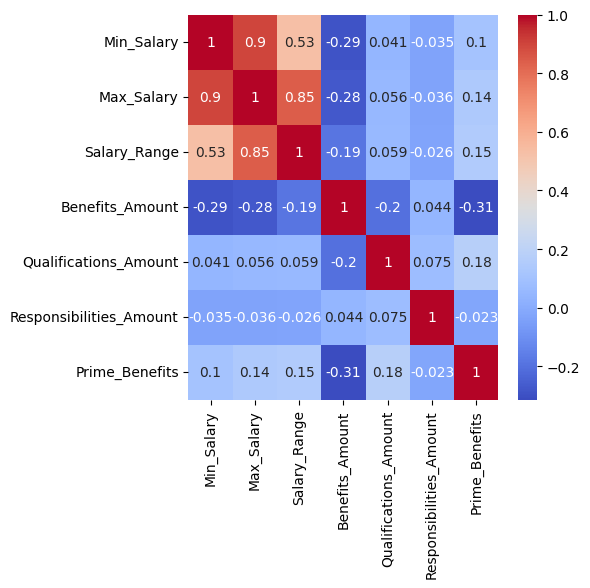

In [136]:
# heatmap of correlations
plt.figure(figsize=(5,5))
sns.heatmap(all.corr(), annot=True, cmap='coolwarm')

<Axes: xlabel='Prime_Benefits', ylabel='Salary_Range'>

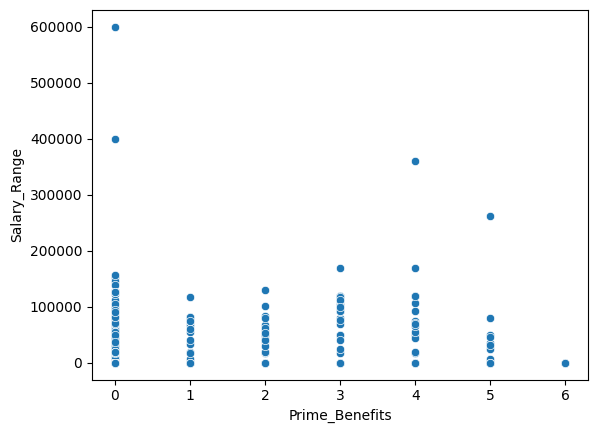

In [137]:
# scatterplot of prime benefits vs salary range
sns.scatterplot(x='Prime_Benefits', y='Salary_Range', data=all)

<Axes: xlabel='Responsibilities_Amount', ylabel='Max_Salary'>

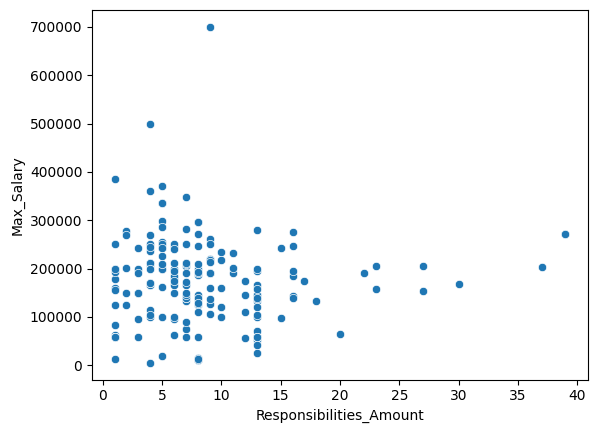

In [138]:
# scatterplot of responsibilities vs max salary, where max salary is not 0.0
sns.scatterplot(x='Responsibilities_Amount', y='Max_Salary', data=all[all['Max_Salary'] > 5000])

<Axes: xlabel='Responsibilities_Amount', ylabel='Min_Salary'>

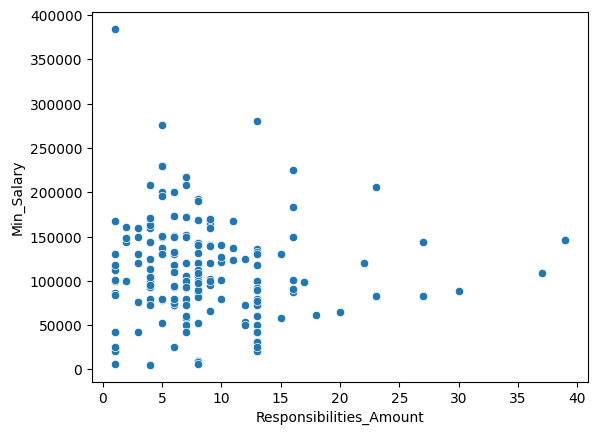

In [139]:
sns.scatterplot(x='Responsibilities_Amount', y='Min_Salary', data=all[all['Min_Salary'] > 5000])

array([[<Axes: title={'center': 'Min_Salary'}>,
        <Axes: title={'center': 'Max_Salary'}>,
        <Axes: title={'center': 'Salary_Range'}>],
       [<Axes: title={'center': 'Benefits_Amount'}>,
        <Axes: title={'center': 'Qualifications_Amount'}>,
        <Axes: title={'center': 'Responsibilities_Amount'}>],
       [<Axes: title={'center': 'Prime_Benefits'}>, <Axes: >, <Axes: >]],
      dtype=object)

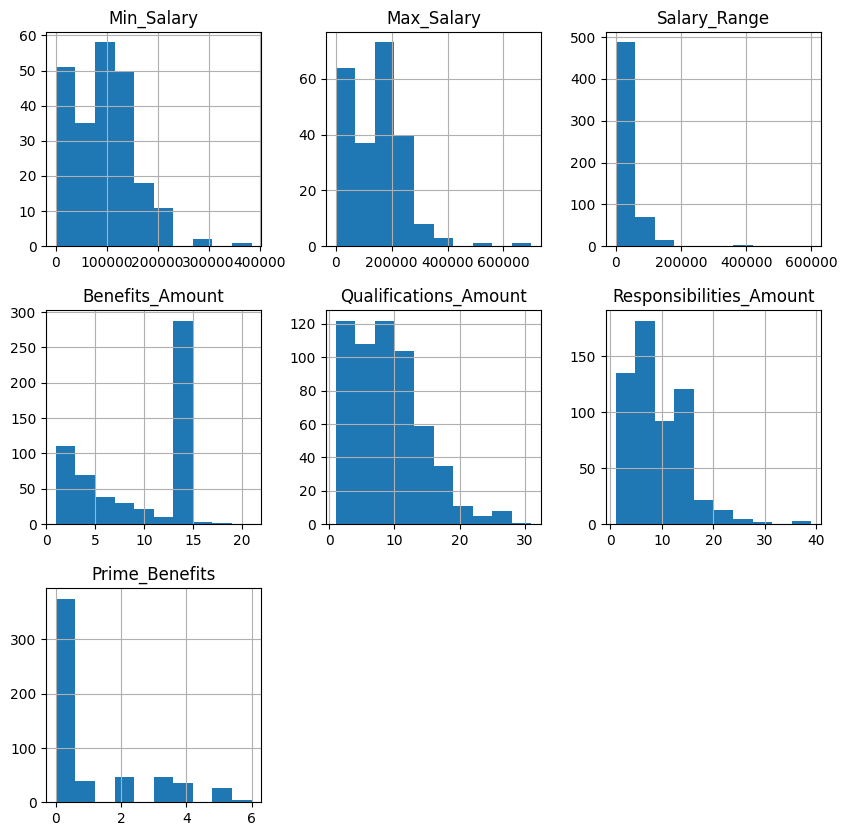

In [140]:
# change min and max salary 0.0 to NaN
all['Min_Salary'] = all['Min_Salary'].replace(0.0, np.nan)
all['Max_Salary'] = all['Max_Salary'].replace(0.0, np.nan)

# histograms of numerical columns
all.hist(figsize=(10,10))

In [141]:
# return rows where Company is Upwork
all[all['Company'] == 'Upwork']

,Title,Company,Location,Via,Description,Schedule,Days_Posted,work_from_home,Qualifications,Responsibilities,Benefits,Search_Location,Min_Salary,Max_Salary,Salary_Range,Benefits_Amount,Qualifications_Amount,Responsibilities_Amount,Prime_Benefits
3,Python based Blockchain,Upwork,Anywhere,Upwork,Need someone to join our existing team to spee...,Contractor,2,True,"[Candidates must be willing to sign, non-discl...",[Will discuss details with the selected candid...,Not Available,DC,20870.0,62610.0,41740.0,13,1,1,0
18,Natural Language Processing,Upwork,Anywhere,Upwork,We are seeking an NLP Engineer to build AI sys...,Contractor,2,True,"[Degree in Computer Science, Engineering, or r...",[They will work on tasks such as text analysis...,Not Available,DC,NaN,NaN,0.0,13,2,2,0
106,python or Matlab,Upwork,Anywhere,Upwork,implement a Deep Reinforcement Learning in Col...,Contractor,2,True,[implement a Deep Reinforcement Learning in Co...,Not Available,Not Available,DC,NaN,NaN,0.0,13,3,13,0
117,Implementing Recurrent Neural,Upwork,Anywhere,Upwork,Implement Recurrent Neural Network for the dat...,Contractor,5,True,[Implement Recurrent Neural Network for the da...,Not Available,Not Available,DC,NaN,NaN,0.0,13,1,13,0
157,Senior machine learning,Upwork,Anywhere,Upwork,I am looking for a Senior machine learning eng...,Contractor,3,True,[I am looking for a Senior machine learning en...,Not Available,Not Available,DC,73045.0,146090.0,73045.0,13,1,13,0
160,Need Consulting on,Upwork,Anywhere,Upwork,I have a dataset of Images that were created f...,Contractor,NaN,True,[What I head in mind was some kind of combinat...,[Evaluate the different types of deep neural n...,Not Available,DC,NaN,NaN,0.0,13,2,2,0
163,Expert in Xgboost/,Upwork,Anywhere,Upwork,We require the services of a Machine Learning ...,Contractor,2,True,[Any previous successes in Kaggle competitions...,Not Available,Not Available,DC,20870.0,52175.0,31305.0,13,1,13,0
165,Building Artificial Neural,Upwork,Anywhere,Upwork,Build artificial neural networks with a given ...,Contractor,23,True,[Previous experience in developing neural netw...,Not Available,Not Available,DC,31305.0,41740.0,10435.0,13,2,13,0
167,Deep Learning Expert,Upwork,Anywhere,Upwork,We are seeking an experienced Deep Learning De...,Contractor,3,True,[The ideal candidate should have at least 2 ye...,"[Design, develop, and implement deep learning ...",[Competitive compensation and an attractive be...,DC,NaN,NaN,0.0,2,2,4,0
182,Expert on Graph,Upwork,Anywhere,Upwork,We are looking for an expert in Graph Neural N...,Contractor,3,True,[Develop and implement GNN models using PyG fo...,Not Available,Not Available,DC,73045.0,104350.0,31305.0,13,3,13,0


In [142]:
all['Schedule'].value_counts()

Full-time     509
Contractor     50
Internship     12
Part-time       3
Name: Schedule, dtype: int64

In [143]:
all['work_from_home'].value_counts()

True    156
Name: work_from_home, dtype: int64

In [144]:
for x in all['Min_Salary']:
    print(x)

nan
170000.0
nan
20870.0
nan
100000.0
nan
150000.0
136000.0
nan
nan
53300.0
nan
110.0
130000.0
118300.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
10000.0
105200.0
nan
nan
58400.0
nan
nan
nan
nan
nan
nan
78000.0
nan
118300.0
nan
nan
225000.0
nan
112000.0
nan
200800.0
86425.0
nan
nan
nan
nan
nan
nan
93300.0
nan
nan
5250.0
nan
nan
nan
87632.0
nan
nan
91000.0
nan
nan
nan
nan
nan
nan
nan
10000.0
20.0
nan
nan
nan
nan
142350.0
120000.0
nan
nan
nan
nan
142350.0
nan
nan
41740.0
146300.0
nan
92400.0
41740.0
80000.0
nan
41740.0
146300.0
50000.0
nan
nan
161000.0
151000.0
nan
200000.0
nan
nan
189.0
nan
80.0
nan
nan
nan
nan
nan
100000.0
nan
nan
130.0
86000.0
20.0
80.0
93300.0
nan
50000.0
nan
137000.0
nan
nan
73100.0
nan
nan
100000.0
110574.0
99138.0
140.0
200.0
73100.0
nan
nan
105900.0
73100.0
100900.0
150.0
150000.0
172020.0
nan
nan
73045.0
140000.0
173000.0
nan
nan
80.0
20870.0
nan
31305.0
nan
nan
113500.0
80000.0
nan
nan
160000.0
nan
41740.0
nan
nan
170112.0
nan
86000.0
nan
73045.0
80.0
nan
20870.0

In [145]:
all['Min_Salary']

0           NaN
1      170000.0
2           NaN
3       20870.0
4           NaN
         ...   
806         NaN
807    150000.0
812         NaN
815    160000.0
820         NaN
Name: Min_Salary, Length: 575, dtype: float64

In [146]:
all['Max_Salary']

0           NaN
1      190000.0
2           NaN
3       62610.0
4           NaN
         ...   
806         NaN
807    250000.0
812         NaN
815    250000.0
820         NaN
Name: Max_Salary, Length: 575, dtype: float64

In [177]:
# select min and max salary columns and remove NaNs and 0.0s
salaries = all[['Min_Salary', 'Max_Salary', 'Salary_Range']]
salaries = salaries.dropna()
salaries = salaries[salaries['Min_Salary'] != 0.0]
salaries = salaries[salaries['Max_Salary'] != 0.0]
salaries = salaries[salaries['Salary_Range'] != 0.0]

# if max salary is under 1000, multiply by 2087
salaries['Max_Salary'] = salaries['Max_Salary'].apply(lambda x: x * 2087 if x < 1000 else x)

# if min salary is under 1000, multiply by 2087
salaries['Min_Salary'] = salaries['Min_Salary'].apply(lambda x: x * 2087 if x < 1000 else x)

# remove those with over 400000 max salary
salaries = salaries[salaries['Max_Salary'] < 400000]

In [249]:
import plotly.graph_objects as go

import numpy as np

x0 = salaries['Min_Salary']
x1 = salaries['Max_Salary']
x2 = salaries['Salary_Range']

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, nbinsx=40, name='Min Salary'))
fig.add_trace(go.Histogram(x=x1, nbinsx=40, name='Max Salary'))
fig.add_trace(go.Histogram(x=x2, nbinsx=40, name='Salary Range'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.7)
fig.update_layout(title="<b>Salary Min, Max, and Range Distribution</b><br><sub>Figure 3.1</sub>",
                  title_x=0.5,
                  title_y=0.85,
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  font=dict(color='rgb(232, 232, 232)'),
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=True),
                  xaxis_title="Salary",
                  yaxis_title="Count",
                  legend=dict(x=.8, y=.8))
#fig.show()

import plotly.io as pio

# create the plotly figure (assume you already have this code)

# export the figure to an HTML file with interactivity
html_file = "histograms.html"
pio.write_html(fig, file=html_file, auto_open=False)

In [251]:
x0 = all[all['Benefits'].apply(lambda x: len(x) < 13 and x != 'Not Available')]['Benefits_Amount']
x1 = all[all['Benefits'].apply(lambda x: len(x) < 13 and x != 'Not Available')]['Prime_Benefits']

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, name='Benefits', marker_color='yellow'))
fig.add_trace(go.Histogram(x=x1, name='Prime Benefits', marker_color='purple'))

# Overlay both histograms
fig.update_layout(barmode='overlay')

fig.update_layout(title="<b>Benefits and Prime Benefits Distribution</b><br><sub>Figure 3.2</sub>",
                  title_x=0.5,
                  title_y=0.85,
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  font=dict(color='rgb(232, 232, 232)'),
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=True),
                  xaxis_title="Benefits",
                  yaxis_title="Count",
                  legend=dict(x=.8, y=.8))

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.7)

# fig.show()

# import plotly.io as pio
html_file = "benefits.html"
pio.write_html(fig, file=html_file, auto_open=False)